# Previsão de demanda energética

Previsão de 1 hora na frente utilizando apenas uma rede.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob, os
import seaborn as sb
import statsmodels.api as sm


C:\Users\Pedro\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Carregar dataset residencial

In [2]:
casas = {}
for i, filePath in enumerate(sorted(glob.glob('Residencia/*.csv'))):
    casas[i] = pd.read_csv(filePath).filter(['date', 'activeEnergy', 'cepa', 'cepb', 'cepc'])
    #casas[i] = casas[i].dropna(axis = 'columns', how = 'all')
    casas[i]['date'] = pd.to_datetime(casas[i]['date'], yearfirst=True, dayfirst= True, errors = 'coerce')
    casas[i]['weekDay'] = casas[i]['date'].dt.weekday
    casas[i]['hours'] = casas[i]['date'].dt.hour
    casas[i]['EnergyNextHour'] = casas[i]['activeEnergy'].shift(-1)
    casas[i]['EnergyNext2Hours'] = casas[i]['activeEnergy'].shift(-2)
    casas[i].drop(casas[i].index[-3:], inplace = True)
    #casas[i].dropna(axis = 0, how = 'any', inplace = True)
    
    #casas[i] = casas[i][casas[i]['activeEnergy'] < 4*casas[i]['activeEnergy'].std()]

In [3]:
a = 2

In [4]:
print(pd.isnull(casas[a]).any())
#df.loc[df['column_name'] == some_value]

casas[a].head()

date                False
activeEnergy        False
cepa                False
cepb                False
cepc                False
weekDay             False
hours               False
EnergyNextHour      False
EnergyNext2Hours    False
dtype: bool


,date,activeEnergy,cepa,cepb,cepc,weekDay,hours,EnergyNextHour,EnergyNext2Hours
0,2017-03-01 00:00:00,1408,192,548,668,2,0,1316.0,1297.0
1,2017-03-01 01:00:00,1316,184,512,620,2,1,1297.0,1278.0
2,2017-03-01 02:00:00,1297,171,509,617,2,2,1278.0,1279.0
3,2017-03-01 03:00:00,1278,174,499,605,2,3,1279.0,1239.0
4,2017-03-01 04:00:00,1279,187,492,600,2,4,1239.0,1255.0


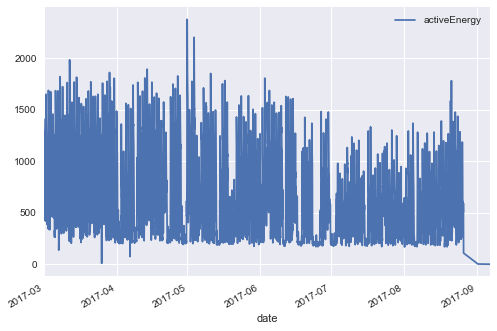

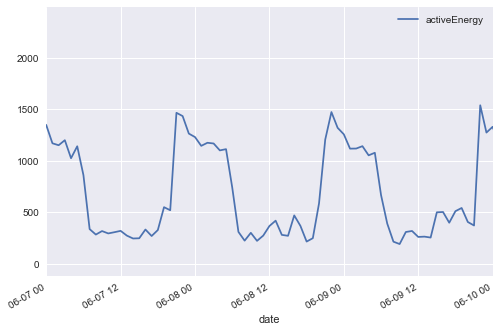

In [5]:
casas[a].plot(x = 'date', y = ['activeEnergy'])#, xlim = ['2017-03-01 00:00:00', ['2017-03-02 00:00:00']])
plt.show()
casas[a].plot(x = 'date', y = ['activeEnergy'], xlim = ['2017-06-07 00:00:00', ['2017-06-10 00:00:00']])
plt.show()

## Truncar os dados

In [6]:
train_set = casas[a][casas[a]['date'] < '2017-08-15 00:00:00']
test_set = casas[a][casas[a]['date'] > '2017-08-15 00:00:00']#.reset_index()

## Retirar tendência

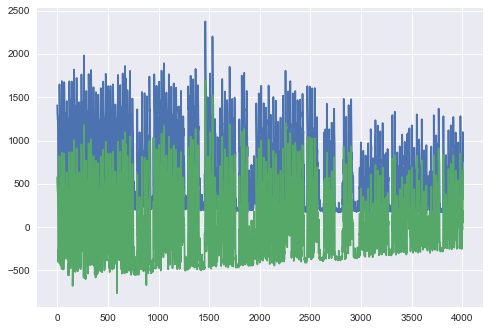

In [7]:
from sklearn.linear_model import LinearRegression
linearReg = LinearRegression()
#print(train_set.index.shape, train_set['activeEnergy'].shape)
linearReg.fit(train_set.index[:, np.newaxis], train_set['activeEnergy'])
train_set_without_tendency = train_set['activeEnergy'] - linearReg.predict(train_set.index[:, np.newaxis])
plt.plot(train_set['activeEnergy'])
plt.plot(train_set_without_tendency)
plt.show()

In [8]:
F = train_set.set_index('date')
#print(F.index.freq)
s = sm.tsa.seasonal_decompose(F.activeEnergy)

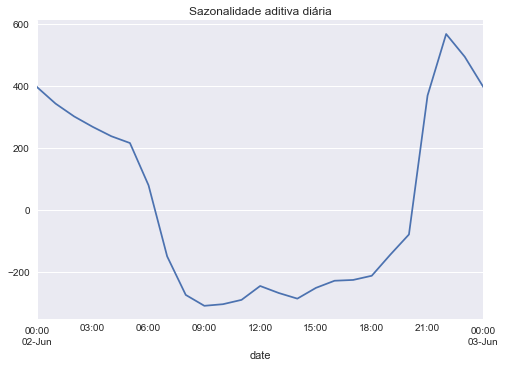

In [9]:
s.seasonal.plot(xlim = ['2017-06-02', '2017-06-03'])
plt.title('Sazonalidade aditiva diária')
plt.show()

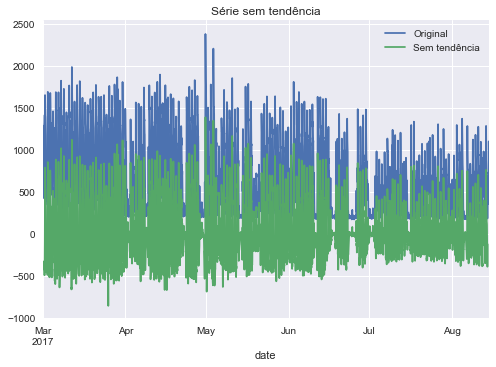

In [10]:
train_set_without_tendency = train_set.set_index('date')['activeEnergy'] - s.trend
train_set.set_index('date').plot(y = ['activeEnergy'])
train_set_without_tendency.plot()
plt.title('Série sem tendência')
plt.legend(['Original', 'Sem tendência'])
plt.show()

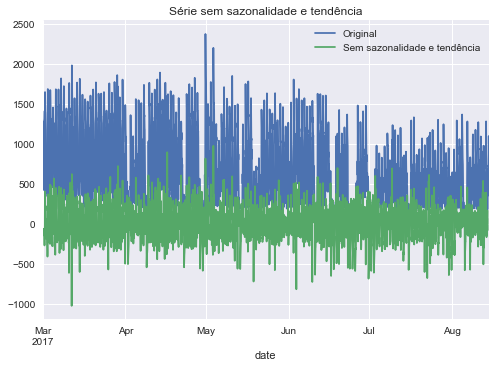

In [11]:
train_set_without_season = train_set_without_tendency - s.seasonal
train_set.set_index('date').plot(y = ['activeEnergy'])
train_set_without_season.plot()
plt.legend(['Original', 'Sem sazonalidade e tendência'])
plt.title('Série sem sazonalidade e tendência')
plt.show()


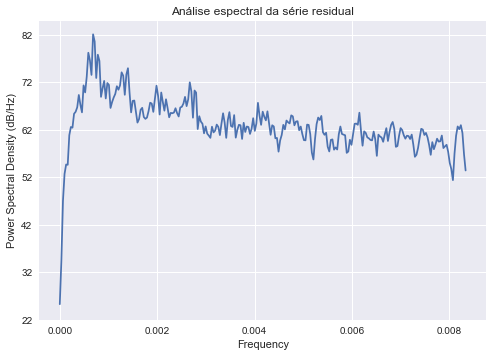

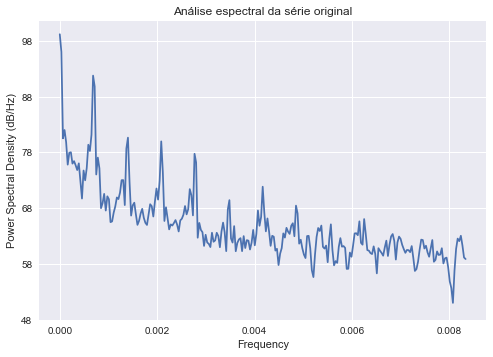

In [12]:
plt.psd(s.resid.dropna(), NFFT = 512, Fs = 1/60)
plt.title('Análise espectral da série residual')
plt.show()
plt.psd(F.activeEnergy.dropna(), NFFT = 512, Fs = 1/60)
plt.title('Análise espectral da série original')
plt.show()

In [13]:
train_set.set_index('date', inplace = True)
train_set['ResidualSeries'] = s.resid
train_set['SeasonalSeries'] = s.seasonal
train_set['TrendSeries'] = s.trend
train_set.dropna(axis = 0, how = 'any', inplace = True)
train_set.head()

C:\Users\Pedro\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Pedro\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Pedro\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

,activeEnergy,cepa,cepb,cepc,weekDay,hours,EnergyNextHour,EnergyNext2Hours,ResidualSeries,SeasonalSeries,TrendSeries
date,,,,,,,,,,,
2017-03-01 12:00:00,513,273,33,207,2,12,575.0,483.0,-144.006249,-245.827084,902.833333
2017-03-01 13:00:00,575,335,40,200,2,13,483.0,550.0,-61.558834,-268.503666,905.062500
2017-03-01 14:00:00,483,307,38,138,2,14,550.0,446.0,-139.123970,-286.688530,908.812500
2017-03-01 15:00:00,550,301,8,241,2,15,446.0,418.0,-110.017670,-251.898997,911.916667
2017-03-01 16:00:00,446,294,5,147,2,16,418.0,420.0,-239.082931,-228.896236,913.979167


In [14]:
test_set.set_index('date', inplace = True)
test_set = test_set[:'2017-08-26']
print(test_set.index.freq)
test_set.tail()

None


,activeEnergy,cepa,cepb,cepc,weekDay,hours,EnergyNextHour,EnergyNext2Hours
date,,,,,,,,
2017-08-26 06:00:00,537,159,158,220,5,6,505.0,591.0
2017-08-26 07:00:00,505,142,101,262,5,7,591.0,430.0
2017-08-26 08:00:00,591,298,40,253,5,8,430.0,108.0
2017-08-26 09:00:00,430,261,-1,170,5,9,108.0,2.0
2017-08-26 10:00:00,108,82,6,20,5,10,2.0,0.0


In [15]:
#test_set.set_index('date', inplace = True)
F = test_set.activeEnergy
sTest = sm.tsa.seasonal_decompose(F, freq = 24)
test_set['ResidualSeries'] = sTest.resid
test_set['SeasonalSeries'] = sTest.seasonal
test_set['TrendSeries'] = sTest.trend
test_set.dropna(axis = 0, how = 'any', inplace = True)
test_set.head()

,activeEnergy,cepa,cepb,cepc,weekDay,hours,EnergyNextHour,EnergyNext2Hours,ResidualSeries,SeasonalSeries,TrendSeries
date,,,,,,,,,,,
2017-08-15 13:00:00,228,146,24,58,1,13,225.0,435.0,74.418868,-350.439702,504.020833
2017-08-15 14:00:00,225,182,10,33,1,14,435.0,594.0,75.894247,-357.435914,506.541667
2017-08-15 15:00:00,435,348,37,50,1,15,594.0,259.0,132.005990,-208.443490,511.437500
2017-08-15 16:00:00,594,371,44,179,1,16,259.0,259.0,302.038187,-222.559020,514.520833
2017-08-15 17:00:00,259,207,10,42,1,17,259.0,297.0,-42.637950,-212.028717,513.666667


## Pré processamento dos dados

In [16]:
matrix =  casas[a].as_matrix(columns = ['activeEnergy', 'cepa', 'cepb', 'cepc', 'weekDay', 
                                        'hours', 'EnergyNextHour', 'EnergyNext2Hours']).T
print(matrix.shape)
correlationCoef = np.corrcoef(matrix[:,3:])

(8, 4311)


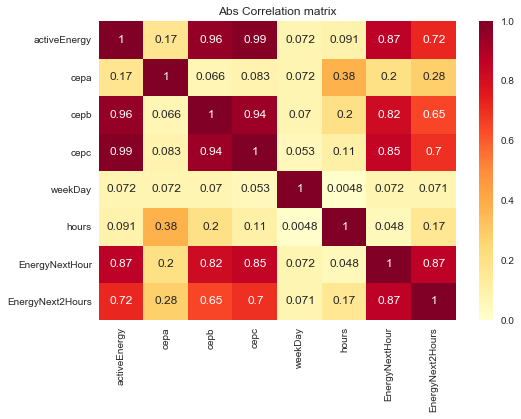

In [17]:
sb.heatmap(np.abs(correlationCoef),
           annot=True, cmap = 'YlOrRd', vmin = 0, vmax =  1,
          xticklabels = ['activeEnergy', 'cepa', 'cepb', 'cepc', 'weekDay', 'hours', 'EnergyNextHour', 'EnergyNext2Hours'],
          yticklabels = ['activeEnergy', 'cepa', 'cepb', 'cepc', 'weekDay', 'hours', 'EnergyNextHour', 'EnergyNext2Hours'])
plt.title('Abs Correlation matrix')
plt.show()

## Regressão com Multilayer Perceptron

In [18]:
from keras.models import Sequential
from keras.layers import Dense

Using Theano backend.


In [19]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])

    return np.array(dataX), np.array(dataY)

In [20]:
train_set.shape
#create_dataset(train_series, look_back = 6)

(3984, 11)

In [21]:
#len(train_set['ResidualSeries'].values)
train_values = train_set['ResidualSeries'].values
train_mean = train_set['ResidualSeries'].mean()
train_std = train_set['ResidualSeries'].std()
train_values -= train_mean
train_values /= train_std


test_values = test_set['ResidualSeries'].values
test_mean = test_set['ResidualSeries'].mean()
test_std = test_set['ResidualSeries'].std()
test_values -= test_mean
test_values /= test_std

x, y = create_dataset(train_values, look_back = 6)
testx, testy = create_dataset(test_values, look_back = 6)
print(y[:10], '\n',train_values[:10])

[-1.30082785 -0.78276327 -0.0438935   1.9399958   1.04458519  0.9207727
  0.79001312  0.9148545   1.07973498  0.95330323] 
 [-0.69117614 -0.29497605 -0.66771441 -0.52784442 -1.14806603 -1.29195024
 -1.30082785 -0.78276327 -0.0438935   1.9399958 ]


In [22]:
model = Sequential()
model.add(Dense(32, input_dim = 6, activation = 'tanh'))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [23]:
history = model.fit(x, y, epochs = 200, validation_split = 0.2, batch_size = 41, verbose =  2)

Train on 3181 samples, validate on 796 samples
Epoch 1/200
0s - loss: 0.6369 - val_loss: 0.4520
Epoch 2/200
0s - loss: 0.5590 - val_loss: 0.4408
Epoch 3/200
0s - loss: 0.5486 - val_loss: 0.4361
Epoch 4/200
0s - loss: 0.5455 - val_loss: 0.4323
Epoch 5/200
0s - loss: 0.5395 - val_loss: 0.4306
Epoch 6/200
0s - loss: 0.5347 - val_loss: 0.4268
Epoch 7/200
0s - loss: 0.5343 - val_loss: 0.4265
Epoch 8/200
0s - loss: 0.5306 - val_loss: 0.4230
Epoch 9/200
0s - loss: 0.5301 - val_loss: 0.4222
Epoch 10/200
0s - loss: 0.5280 - val_loss: 0.4208
Epoch 11/200
0s - loss: 0.5244 - val_loss: 0.4211
Epoch 12/200
0s - loss: 0.5250 - val_loss: 0.4199
Epoch 13/200
0s - loss: 0.5224 - val_loss: 0.4204
Epoch 14/200
0s - loss: 0.5208 - val_loss: 0.4211
Epoch 15/200
0s - loss: 0.5216 - val_loss: 0.4195
Epoch 16/200
0s - loss: 0.5197 - val_loss: 0.4132
Epoch 17/200
0s - loss: 0.5184 - val_loss: 0.4156
Epoch 18/200
0s - loss: 0.5180 - val_loss: 0.4153
Epoch 19/200
0s - loss: 0.5168 - val_loss: 0.4122
Epoch 20/200

0s - loss: 0.4941 - val_loss: 0.4062
Epoch 166/200
0s - loss: 0.4912 - val_loss: 0.4219
Epoch 167/200
0s - loss: 0.4965 - val_loss: 0.4068
Epoch 168/200
0s - loss: 0.4915 - val_loss: 0.4051
Epoch 169/200
0s - loss: 0.4943 - val_loss: 0.4068
Epoch 170/200
0s - loss: 0.4945 - val_loss: 0.4103
Epoch 171/200
0s - loss: 0.4926 - val_loss: 0.4065
Epoch 172/200
0s - loss: 0.4909 - val_loss: 0.4050
Epoch 173/200
0s - loss: 0.4911 - val_loss: 0.4076
Epoch 174/200
0s - loss: 0.4955 - val_loss: 0.4073
Epoch 175/200
0s - loss: 0.4938 - val_loss: 0.4086
Epoch 176/200
0s - loss: 0.4939 - val_loss: 0.4037
Epoch 177/200
0s - loss: 0.4914 - val_loss: 0.4072
Epoch 178/200
0s - loss: 0.4917 - val_loss: 0.4065
Epoch 179/200
0s - loss: 0.4922 - val_loss: 0.4062
Epoch 180/200
0s - loss: 0.4917 - val_loss: 0.4050
Epoch 181/200
0s - loss: 0.4920 - val_loss: 0.4066
Epoch 182/200
0s - loss: 0.4912 - val_loss: 0.4070
Epoch 183/200
0s - loss: 0.4885 - val_loss: 0.4116
Epoch 184/200
0s - loss: 0.4936 - val_loss: 0

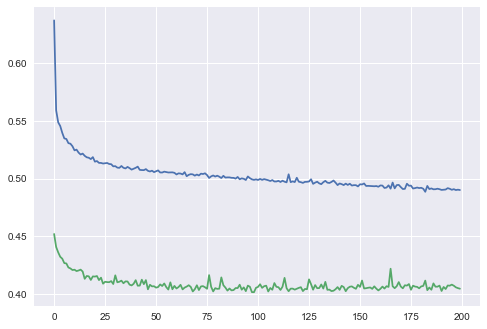

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [25]:
predictedTest = model.predict(testx)
ploting = predictedTest*test_std + test_mean 
ploting += test_set['SeasonalSeries'].values[5:-2, np.newaxis] +test_set['TrendSeries'].values[5:-2, np.newaxis]
print(test_std, test_mean)
print(test_set['SeasonalSeries'].values.shape, test_set['TrendSeries'].values.shape)
print(predictedTest.shape, ploting.shape)


178.1663610617089 3.8393229166667258
(249,) (249,)
(242, 1) (242, 1)


In [28]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(mean_absolute_percentage_error(test_set['activeEnergy'][5:-2].values, ploting))

80.7466976312


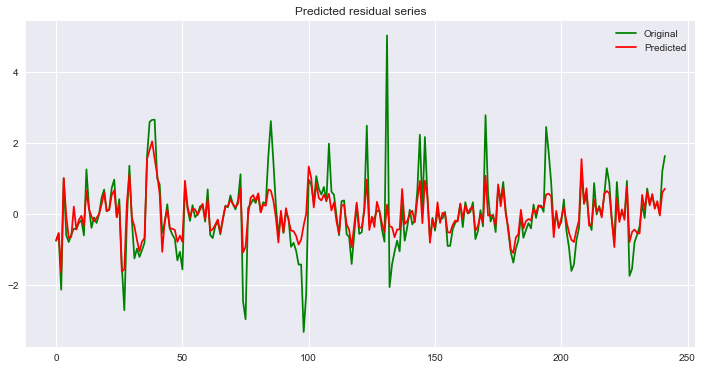

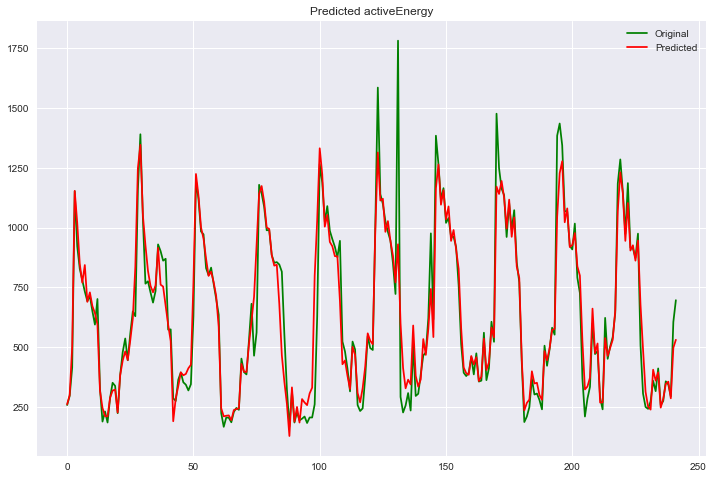

In [27]:
plt.figure(figsize = (12,6))
plt.title('Predicted residual series')
plt.plot(test_set['ResidualSeries'][5:-2].values, 'g')
plt.plot(predictedTest, 'r')
plt.legend(['Original', 'Predicted'])
plt.show()

plt.figure(figsize = (12,8))
plt.title('Predicted activeEnergy')
plt.plot(test_set['activeEnergy'][5:-2].values, 'g')
plt.plot(ploting, 'r')
plt.legend(['Original', 'Predicted'])
#plt.text('MSE %.3f'%)
plt.show()
